In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import BackendSamplerV2
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel 
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import sys
from qiskit.visualization import plot_histogram
from math import floor, gcd, log
import numpy as np
from qiskit.circuit.library import QFTGate
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from fractions import Fraction
import sys

In [10]:
N = 15
a = 2

In [11]:
assert np.mod(N,a) != 0, f"The given value a = {a} is already a factor of N = {N} with {int(N/a)}"

def shor_candidates(N):
    return [a for a in range(2, N) if gcd(a, N) == 1]

coprime = shor_candidates(15)

assert a in coprime, f"The given a = {a} and N = {N} are not coprime. List of coprime of N = {N} are {coprime}"

In [13]:
#QPE Ua2k mod N
def a2kmodN(a, k, N):
    for _ in range(k):
        a = int(np.mod(a**2, N))
    return a

Qbit_nb = floor(log(N-1, 2)) + 1 #need 4 Qbits to represent the number 15
Control_nb = 2 * Qbit_nb # @ times the nb of Qbit for precision

k_list = range(Control_nb)
b_list = [a2kmodN(a,k, N) for k in k_list]
print(b_list)
#Ma∣y⟩≡∣a*y mod N⟩

[2, 4, 1, 1, 1, 1, 1, 1]


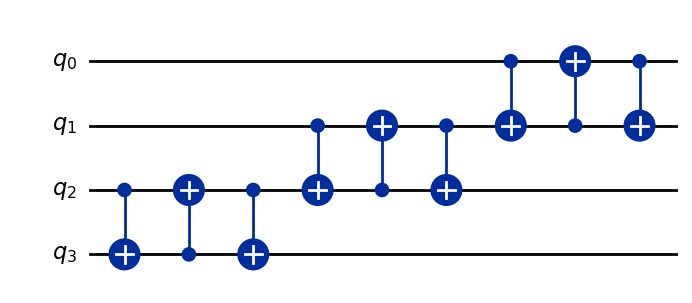

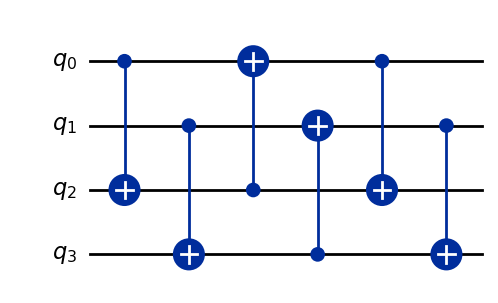

In [14]:
#M2
# here we describe the action M2|1> = |2> ... M2|8> = |1>
# basicly a Qbit shifting
M2 = QuantumCircuit(4)
M2.swap(2,3)
M2.swap(1,2)
M2.swap(0,1)
M2.to_gate()
M2.name = f"M_2"
M2_control = M2.control()
display(M2.decompose().draw("mpl"))
#display(M2.draw("mpl"))


#M4
# here we describe the action M4|1> = |4> and M4|4> = |1>
# basicly a Qbit shifting by 2
M4 = QuantumCircuit(4)
M4.swap(1,3)
M4.swap(0,2)
M4.to_gate()
M4.name = f"M_4"
M4_control = M4.control()
display(M4.decompose().draw("mpl"))
#display(M4.draw("mpl"))

In [16]:
# Here is a theoritical part where we create a gate from a matrix
def Mk(a,k,N):
    dim = 2**Qbit_nb
    U = np.zeros((dim, dim))

    for y in range(dim):
        if y < N:
            new_y = (a * y) % N
        else:
            new_y = y
        U[new_y, y] = 1

    gate = UnitaryGate(U, label=f"M{k}")
    return gate

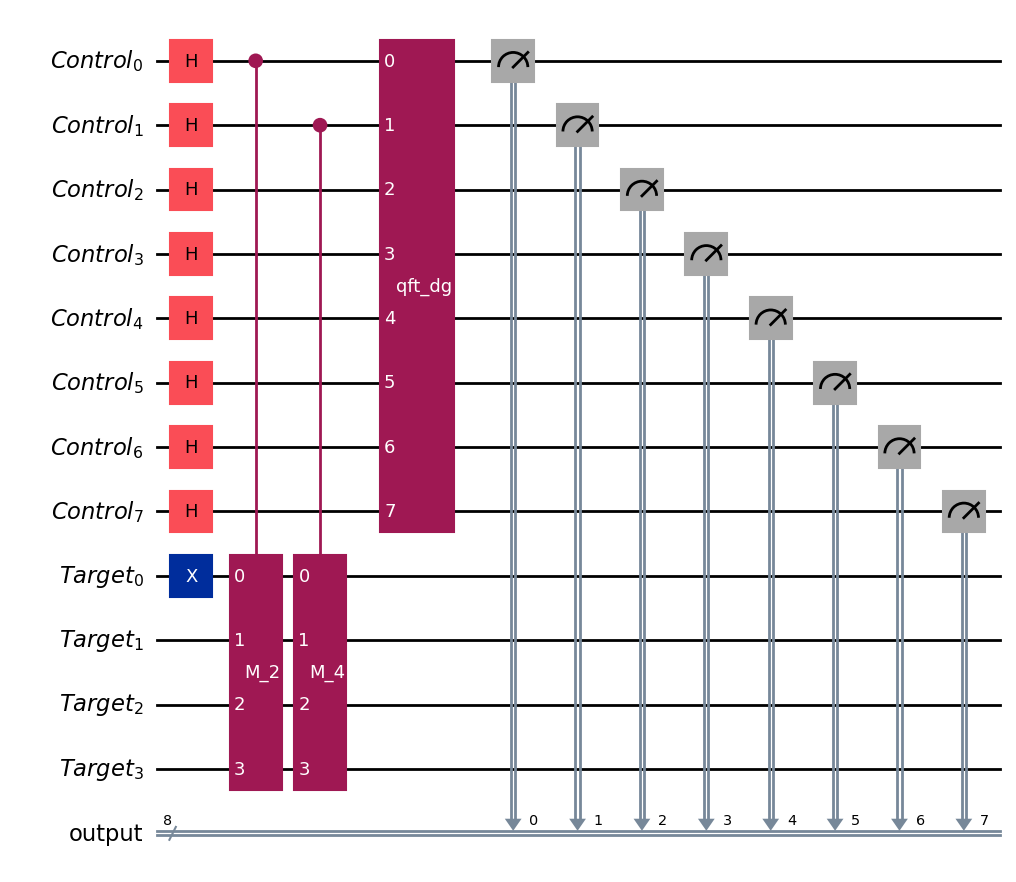

In [19]:
#QCircuits composition
control = QuantumRegister(Control_nb, name="Control")
target = QuantumRegister(Qbit_nb, name="Target")
output = ClassicalRegister(Control_nb, name="output")


#Main circuit
circuit = QuantumCircuit(control, target, output)

#Initialize target to 1
circuit.x(Control_nb)

#here we apply M2 and M4 to the corresponding qubits. And Mk when possible for theoritical purpose
for k, qubit in enumerate(control):
    circuit.h(k)
    b = b_list[k]
    if b == 2:
        circuit.compose(M2_control, qubits=[qubit] + list(target), inplace=True)
    elif b == 4:
        circuit.compose(M4_control, qubits=[qubit] + list(target), inplace=True)
    elif b in coprime:
        circuit.compose(Mk(a, b, N).control(), qubits=[qubit] + list(target), inplace=True)
    

#Then apply QFT gate and measure. (QFT is needed to read Qubits into bits)
circuit.compose(QFTGate(Control_nb).inverse(), qubits=control, inplace=True)
circuit.measure(control, output)
display(circuit.draw("mpl"))


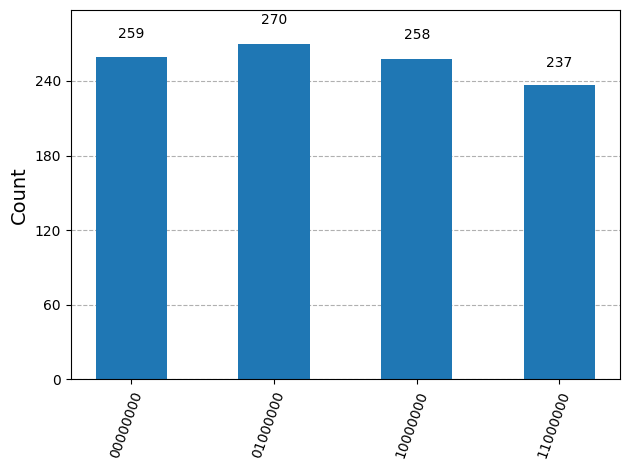

In [20]:
backend_sim = AerSimulator()
sampler_sim = BackendSamplerV2(backend=backend_sim)

target = backend_sim.target
pm = generate_preset_pass_manager(target=target, optimization_level=3, )

sample = 1024
qc_isa = pm.run(circuit)
job = sampler_sim.run([qc_isa],shots=sample)
res = job.result()
counts = res[0].data['output'].get_counts()
display(plot_histogram(counts))

In [21]:
FACTOR_FOUND = False
i = 0

while not FACTOR_FOUND:
    if i >= len(counts):
        break;
    bitstring = list(counts.keys())[i]
    i += 1
    decimal = int(bitstring, 2) #convert bitstring into decimal
    phase = decimal / (2**Control_nb)  # phase = k / r
    frac = Fraction(phase).limit_denominator(N) # transform phase into rational fraction. 
                                              #ex 0,333... into 1/3
    r = frac.denominator  # frac is in the form k/r so we keep r
    if phase != 0:
        if r % 2 == 0:
            x1 = pow(a, r // 2) - 1
            x2 = pow(a, r // 2) + 1
            d1 = gcd(x1, N)
            d2 = gcd(x2, N)
            if d1 > 1:
                if d2 >1:
                    FACTOR_FOUND = True
if FACTOR_FOUND == False:
    print(f"Unable to find factors with a = {a} and N = {N}. Please use an other a")
else:
    print(f"Using a = {a} and N = {N} we get r = {r} which leads to {d1} and {d2}")


Using a = 2 and N = 15 we get r = 4 which leads to 3 and 5
